In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('data_tp1.csv',header=None)
data = data.rename(columns={0:'y'})
data.head(2)

,y,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
from sklearn.model_selection import train_test_split

y = data.y.values
X = data.drop(columns='y').values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [3]:
print(X_train.shape)
print(y_train.shape)
idx = 0
print((X_train[idx,:]).shape)
print(y_train[idx])
(y_train[idx]).shape 

(3350, 784)
(3350,)
(784,)
7


()

In [4]:
from torch.utils.data import DataLoader, Dataset
import torch

# Pytorch exige que seja utilizado um dataset por algum motivo aparentemente
class custom_mnist_dataset():
    def __init__(self, X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Restrições de uso do pytorch: (leia os docs...)
        # inputs tem que ser float para multiplicar pelos pesos, 
        # outputs tem que ser longint para calcular crossentropy 
        return torch.tensor(self.X[idx,:], dtype=torch.float), self.y[idx]

training_data = custom_mnist_dataset(X = X_train, y = y_train)
test_data = custom_mnist_dataset(X = X_test, y = y_test)

# batch_size = 10,50
batch_size = 25

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    

Shape of X [N, C, H, W]: torch.Size([25, 784]) torch.float32
Shape of y: torch.Size([25]) torch.int64


In [5]:


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [6]:
from torch import nn
import torch.nn.functional as F

"""
NeuralNetwork with  ...
"""
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(NeuralNetwork, self).__init__()

        self.entrada = nn.Linear(input_size, hidden_dim)
        self.oculta = nn.Linear(hidden_dim, hidden_dim)
        self.saida = nn.Linear(hidden_dim, output_size)

    def forward(self, input):

        x1 = self.entrada(input)
        x2 = F.sigmoid(self.oculta(x1))
        x3 = self.saida(x2)

        return x3
    
# hidden dim = 25,50,100
print(NeuralNetwork(input_size = X_train.shape[1], hidden_dim= 25, output_size=10).to(device))


NeuralNetwork(
  (entrada): Linear(in_features=784, out_features=25, bias=True)
  (oculta): Linear(in_features=25, out_features=25, bias=True)
  (saida): Linear(in_features=25, out_features=10, bias=True)
)


In [7]:
# https://www.kaggle.com/code/shrutimechlearn/pytorch-custom-model-step-by-step

def train_step(model, loss_func, optimizer, dataloader):
    
    # to capture loss
    train_loss = 0 

    # to get the model in training mode
    model.train()
    
    for batch, (x_batch, y_batch) in enumerate(dataloader):
        # sending data to the device where rest of the artifacts are
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # forward pass/model prediction with the given input
        y_pred = model(x_batch)
        
        # loss calculation by comparison between predicted and ground truth values
        loss = loss_func(y_pred, y_batch)
        train_loss += loss.item()
    
        # setting previously collected gradient values in the optimizer to zero so it translates only current gradients
        optimizer.zero_grad()
        
        # calculate the gradients for this iteration (independent gradients because previous values have been reset to 0)
        loss.backward()
        
        # update the weights and biases based on the calculated gradients ~(wi = wi + delta_wi)
        optimizer.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)

    return train_loss

In [8]:
def test_step(model, loss_func, test_dataloader):
    
    test_loss = 0
    
    model.eval()
    
    
    with torch.inference_mode():
        
        for batch, (x_batch, y_batch) in enumerate(test_dataloader):
            
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            
            loss = loss_func(y_pred, y_batch)
            test_loss+= loss.item()

    test_loss = test_loss/len(test_dataloader)   

    return test_loss
            

In [9]:
# from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
# writer = SummaryWriter()

def train(model, loss_func, optimizer, train_dataloader, test_dataloader, n_epochs):
    
    train_loss = []
    
    test_loss = []
    
    for epoch in range(n_epochs):
        
        tr_loss = train_step(model, loss_func, optimizer, train_dataloader)
        train_loss.append(tr_loss)
    
        ts_loss = test_step(model, loss_func, test_dataloader)
        test_loss.append(ts_loss)       
    
    return train_loss, test_loss

In [10]:
from torch import optim
# https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

# batch_size = 10,50
batch_size = len(training_data)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# hidden dim = 25,50,100
model = NeuralNetwork(input_size = X_train.shape[1], hidden_dim= 25, output_size=10).to(device)

loss_func = nn.CrossEntropyLoss()

# GB, SGD batch 1, SGD minibatch 10 e 50
# lr = 0.5, 1, 10
optimizer = optim.SGD(model.parameters(), lr=0.5)

train_loss, test_loss = train(
      model, 
      loss_func, 
      optimizer, 
      train_dataloader, 
      test_dataloader, 
      n_epochs= 200)

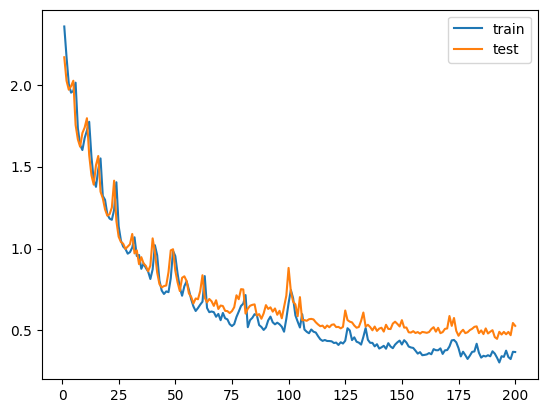

In [11]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

my_plot(np.arange(1,201), train_loss)
my_plot(np.arange(1,201), test_loss)

plt.legend(['train','test'])

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

with torch.no_grad():
    model.eval()
    total_preds = []
    total_labels = []
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        total_preds.extend(preds.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(total_labels, total_preds)
precision = precision_score(total_labels, total_preds, average='weighted')
recall = recall_score(total_labels, total_preds, average='weighted')
f1 = f1_score(total_labels, total_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8375757575757575
Precision: 0.8458846671394749
Recall: 0.8375757575757575
F1 Score: 0.8376386738719243
